In [29]:
import numpy as np
import pandas as pd

import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, classification_report
from aeon.classification.deep_learning import InceptionTimeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import balanced_accuracy_score, f1_score

import src.data_loader as dl
print(dl.__file__)

import importlib
import src.data_loader as dl
importlib.reload(dl)
import tensorflow as tf


SEED = 42
RNG = np.random.default_rng(SEED)

/Users/liyiling/Documents/Albstadt-Studium/2025WW/Python-Advanced-Herr Seidler/Abschlussprüfung/yiling/src/data_loader.py


## 1. Daten Laden
- ich habe data_loader.py in Verzeichnis src definiert und gestellt.
- mit funktion in data_loader.py lade ich Rohrdaten ein.

In [6]:
from src.data_loader import load_sensor_data, load_target

sensor_data = load_sensor_data()   # dict: {sensor_name: DataFrame (2205, timesteps)}
y = load_target()                  # pd.Series (2205,)
y = y.to_numpy()                   # aeon / sklearn lieber ndarray

print("n_sensors:", len(sensor_data))
print("y shape:", y.shape, "classes:", np.unique(y))

n_sensors: 17
y shape: (2205,) classes: [ 73  80  90 100]


## 2. Data Preparation
- NaN/Inf check
- Resampling to fixed length (60)
- Build multivariate X for aeon: (n_samples, n_channels, n_timepoints)
- Normalization (z-normalization per sample per channel over time axis)

In [7]:
# step1: NaN/Inf check
def check_nan_inf(sensor_dict):
    for name, df in sensor_dict.items():
        x = df.to_numpy()
        n_nan = np.isnan(x).sum()
        n_inf = np.isinf(x).sum()
        if n_nan > 0 or n_inf > 0:
            print(f"[WARN] {name}: NaN={n_nan}, Inf={n_inf}")
    print("NaN/Inf check done.")

check_nan_inf(sensor_data)

NaN/Inf check done.


In [8]:
# step2: Resampling to fixed length (z.B.60)
def resample_to_fixed_length(df: pd.DataFrame, target_len: int = 60) -> np.ndarray:
    '''
    Parameter:
    ----------
    df : pd.DataFrame
        Form (n_samples, old_len), jede Zeile entspricht einem Messzyklus
    target_len : int
        Ziel-Länge der Zeitreihe nach dem Resampling (z.B 60)

    Rückgabe:
    ---------
    np.ndarray
        Array der Form (n_samples, target_len) mit Datentyp float32
    '''

    x = df.to_numpy(dtype=np.float32)
    n, old_len = x.shape

    # wenn old_len == target_len, dann nichts tun
    if old_len == target_len:
        return x

    # wenn old_len != target_len, dann resample
    old_idx = np.linspace(0, 1, old_len, dtype=np.float32)
    new_idx = np.linspace(0, 1, target_len, dtype=np.float32)

    out = np.empty((n, target_len), dtype=np.float32)
    for i in range(n):
        out[i] = np.interp(new_idx, old_idx, x[i])
    return out

In [9]:
# step3: Build multivariate X for aeon: (n_samples, n_channels, n_timepoints)

# Ziel-Länge der Zeitreihe nach dem Resampling,z.B 60,30..
TARGET_LEN = 60

# Reihenfolge der Sensoren festlegen, damit es konsistent bleibt
SENSOR_ORDER = list(sensor_data.keys())

X_channels = []
for s in SENSOR_ORDER:
    # resample each sensor data to fixed length, e.g., 60
    arr = resample_to_fixed_length(sensor_data[s], target_len=TARGET_LEN)  # (2205, 60)
    X_channels.append(arr)

# build final X
# the shape should be (n_samples, n_channels, n_timepoints)
X = np.stack(X_channels, axis=0)                 # (n_channels, n_samples, 60)
X = np.transpose(X, (1, 0, 2)).astype(np.float32) # (n_samples, n_channels, 60)

print("X shape:", X.shape)  # (2205, 17, 60)

X shape: (2205, 17, 60)


In [10]:
# step4: Normalization (z-normalization per sample per channel over time axis)

def z_norm_per_sample_channel(X, eps=1e-8):
    # X:  (n_samples, n_channels, n_timepoints)

    # axis=2: over timepoints, keepdims=true to keep shape for broadcasting
    mean = X.mean(axis=2, keepdims=True)
    std = X.std(axis=2, keepdims=True)

    return (X - mean) / (std + eps) # eps to avoid division by zero

X = z_norm_per_sample_channel(X)

## 3. Trainieren und Evalution

- 3.1 Trainieren mit alle 17 Sensoren
- 3.2 Trainieren mit drei Sensoren basierend auf Ablation von Desicion Tree
- 3.3 Ablation Experiment für Inceptiontime(drei Sensor werden entfernt, nur 14 übrig)
- 3.4 Trainieren mit 8 Sensoren
    - mit Epoch 150, 3 Splits
    - mit Epoch 60, 3 Splits
    - mit Epoch 60, aber 10 Splits
- 3.4 Trainieren mit 14 übrigen Sensoren von Ablation Experiment


In [11]:
def plot_loss_and_accuracy(history_obj, model_name="Model"):
    """
    Visualisiert den Trainingsverlauf (Loss & Accuracy) eines aeon DL-Modells.
    Hinweis: aeon speichert nur Trainingsmetriken (kein Validierungsset).
    Kompatibel mit:
      - keras.callbacks.History (history_obj.history + history_obj.epoch)
      - dict (z.B. {"loss":[...], "accuracy":[...]})
      - pd.DataFrame (Spalten: loss/accuracy)
    """
    if history_obj is None:
        print(f"[{model_name}] Kein History-Objekt gefunden.")
        return

    if history_obj is None:
        print(f"[{model_name}] Kein History-Objekt gefunden.")
        return

    # ---- 1) Keras History ----
    if hasattr(history_obj, "history"):
        hist = history_obj.history
        epochs = getattr(history_obj, "epoch", list(range(1, len(next(iter(hist.values()))) + 1)))
        epochs = np.array(epochs) + 1 if (len(epochs) > 0 and epochs[0] == 0) else np.array(epochs)

    # ---- 2) DataFrame ----
    elif isinstance(history_obj, pd.DataFrame):
        hist = history_obj.to_dict(orient="list")
        epochs = np.arange(1, len(next(iter(hist.values()))) + 1)

    # ---- 3) dict ----
    elif isinstance(history_obj, dict):
        hist = history_obj
        epochs = np.arange(1, len(next(iter(hist.values()))) + 1)

    else:
        print(f"[{model_name}] Unbekanntes History-Format: {type(history_obj)}")
        return

    # keys absichern
    loss_key = "loss" if "loss" in hist else None
    acc_key  = "accuracy" if "accuracy" in hist else ("acc" if "acc" in hist else None)

    fig, ax = plt.subplot_mosaic([["loss", "accuracy"]], figsize=(12, 4))

    if loss_key:
        ax["loss"].plot(epochs, hist[loss_key], label="train loss")
        ax["loss"].set_title(f"{model_name} – Loss history")
        ax["loss"].set_xlabel("Epoch")
        ax["loss"].set_ylabel("Loss")
        ax["loss"].legend()
    else:
        ax["loss"].set_title(f"{model_name} – Loss history (nicht verfügbar)")

    if acc_key:
        ax["accuracy"].plot(epochs, hist[acc_key], label="train accuracy")
        ax["accuracy"].set_title(f"{model_name} – Accuracy history")
        ax["accuracy"].set_xlabel("Epoch")
        ax["accuracy"].set_ylabel("Accuracy")
        ax["accuracy"].legend()
    else:
        ax["accuracy"].set_title(f"{model_name} – Accuracy history (nicht verfügbar)")

    plt.tight_layout()
    plt.show()


In [12]:
def evaluate_aeon_model(model, X, y, dataset_name="Val"):
    print(f"\n=== {dataset_name} Evaluation ===")

    #
    y_pred = model.predict(X)

    #
    proba = model.predict_proba(X)
    print("proba shape:", proba.shape, "dtype:", proba.dtype)
    print("NaN in proba:", np.isnan(proba).any())
    print("Inf in proba:", np.isinf(proba).any())

    # Accuary
    acc = accuracy_score(y, y_pred)
    bal_acc = balanced_accuracy_score(y, y_pred)
    print(f"{dataset_name} Accuracy: {acc:.4f}")
    print(f"{dataset_name} Balanced Accuracy: {bal_acc:.4f}")
    print(classification_report(y, y_pred, digits=3, zero_division=0))

    return acc


In [31]:
def train_inceptiontime_3splits(X, y, base_seed=42):
    results = []

    for k in range(3):
        rs = base_seed + k
        print("\n" + "="*60)
        print(f"Split {k+1}/3 | random_state={rs}")
        print("="*60)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=rs,
            stratify=y
        )

        X_train2, X_val, y_train2, y_val = train_test_split(
            X_train, y_train,
            test_size=0.2,
            random_state=rs,
            stratify=y_train
        )

        model = InceptionTimeClassifier(
            batch_size=16,
            n_epochs=30,
            n_classifiers=2,
            verbose=0,
            random_state=rs
        )

        model.fit(X_train2, y_train2)
        print("model fitted.")

        # ---- Validation / Test Evaluation ----
        val_acc = evaluate_aeon_model(model, X_val, y_val, dataset_name="Validation")
        test_acc = evaluate_aeon_model(model, X_test, y_test, dataset_name="Test")

        # Balanced Accuracy
        y_test_pred = model.predict(X_test)
        bal_acc = balanced_accuracy_score(y_test, y_test_pred)

        # F1 Score
        f1_macro = f1_score(y_test, y_test_pred, average="macro")
        f1_weighted = f1_score(y_test, y_test_pred, average="weighted")

        results.append({
            "split": k + 1,
            "random_state": rs,
            "val_accuracy": val_acc,
            "test_accuracy": test_acc,
            "test_balanced_accuracy": bal_acc,
            "test_f1_macro": f1_macro,
            "test_f1_weighted": f1_weighted
        })

    results_df = pd.DataFrame(results)

    print("\n=== Summary (3 splits) ===")
    print(results_df)

    print("\nTest Balanced Acc mean:",
          results_df["test_balanced_accuracy"].mean().round(4))
    print("Test Balanced Acc std :",
          results_df["test_balanced_accuracy"].std(ddof=1).round(4))

    return results_df


In [23]:
def summarize_3splits_results(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    Die Ergebnisse von 3 splits werden in 1 Zeile summary_df（mean/std） zusammengefasst
    """
    summary = {
        "balanced_accuracy_mean": results_df["test_balanced_accuracy"].mean(),
        "balanced_accuracy_std":  results_df["test_balanced_accuracy"].std(ddof=1),

        "f1_macro_mean": results_df["test_f1_macro"].mean(),
        "f1_macro_std":  results_df["test_f1_macro"].std(ddof=1),

        "f1_weighted_mean": results_df["test_f1_weighted"].mean(),
        "f1_weighted_std":  results_df["test_f1_weighted"].std(ddof=1),
    }
    return pd.DataFrame([summary])

### 3.1 alle 17 Sensoren
- Epoch=30
- Batchsize=16

In [14]:
# alle 17 Sensoren zum Trainieren als Baseline
train_inceptiontime_3splits(X, y, base_seed=SEED)


Split 1/3 | random_state=42
model fitted.
history-like attrs: []
[Split 1] Kein History-Objekt gefunden -> Plot wird übersprungen.

=== Validation Evaluation ===
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
proba shape: (353, 4) dtype: float64
NaN in proba: False
Inf in proba: False
Validation Accuracy: 0.9263
Validation Balanced Accuracy: 0.9201
              precision    recall  f1-score   support

          73      1.000     1.000     1.000        57
          80      1.000     0.966     0.982        58
          90      0.776     0.776     0.776        58
         100      0.929     0.939     0.934       180

    accuracy                          0.926       353
   macro avg      0.926     0.920     0.923       353
weighted avg      0.927     0.926     0.926       353


=== Test Evaluation ===
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

,split,random_state,val_accuracy,test_accuracy,test_balanced_accuracy,test_f1_macro,test_f1_weighted
0,1,42,0.926346,0.936508,0.926389,0.930367,0.935463
1,2,43,0.917847,0.936508,0.921667,0.931606,0.935015
2,3,44,0.929178,0.934240,0.913472,0.925153,0.933098


### 3.2 Trainieren mit 3 Sensoren
Basierend auf Ablation von Desicion Tree ist die beste Drei-Sensor-Kombination "PS2",  "TS2", "PS1"

In [15]:
# Funktion zum Erstellen von multivariaten X
# mit mehr als einem Sensor, muss auch das Datenformat an Aeon anpassen

def build_multivariate_X(
    sensor_data: dict,
    target_len: int = 60,
    sensor_order: list | None = None,
    resample_fn=None,
    dtype=np.float32
) -> np.ndarray:
    """
    Erstellt aus mehreren Sensorsignalen ein multivariates Zeitreihen-Array
    im von aeon erwarteten Format (n_samples, n_channels, n_timepoints).
    Dabei werden alle Sensorsignale auf eine einheitliche Länge resampelt
    und in einer festen Kanalreihenfolge zusammengeführt.
    """

    if resample_fn is None:
        raise ValueError("resample_fn must be provided")

    # 1) Reihenfolge der Sensoren festlegen
    if sensor_order is None:
        sensor_order = list(sensor_data.keys())

    # 2) Resample each sensor data to fixed length
    X_channels = []
    for s in sensor_order:
        if s not in sensor_data:
            raise KeyError(f"Sensor '{s}' not found in sensor_data")

        arr = resample_fn(sensor_data[s], target_len=target_len)
        X_channels.append(arr)

    # 3) stack + transpose -> (n_samples, n_channels, n_timepoints)
    X = np.stack(X_channels, axis=0)          # (n_channels, n_samples, target_len)
    X = np.transpose(X, (1, 0, 2)).astype(dtype)

    return X

In [16]:
# Laut des Ergebnis des Ablation Experiment von Desicion Tree sind PS2, TS2, PS1 effizient.
# probieren die drei gute Sensor zum Deep learning Modell Inceptiontime Trainieren.
SELECTED_SENSORS = [
    "PS2",  # Pressure（ PS Gruppe）
    "TS2",   # Temperature（ TS Gruppe）
    "PS1"
]

X_selected = build_multivariate_X(
    sensor_data,
    target_len=60,
    sensor_order=SELECTED_SENSORS,
    resample_fn=resample_to_fixed_length,
    dtype=np.float32
)

In [17]:
train_inceptiontime_3splits(X_selected, y, base_seed=SEED)


Split 1/3 | random_state=42
model fitted.
history-like attrs: []
[Split 1] Kein History-Objekt gefunden -> Plot wird übersprungen.

=== Validation Evaluation ===
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
proba shape: (353, 4) dtype: float64
NaN in proba: False
Inf in proba: False
Validation Accuracy: 0.8499
Validation Balanced Accuracy: 0.7774
              precision    recall  f1-score   support

          73      1.000     1.000     1.000        57
          80      0.909     0.862     0.885        58
          90      0.750     0.259     0.385        58
         100      0.805     0.989     0.888       180

    accuracy                          0.850       353
   macro avg      0.866     0.777     0.789       353
weighted avg      0.845     0.850     0.823       353


=== Test Evaluation ===
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

,split,random_state,val_accuracy,test_accuracy,test_balanced_accuracy,test_f1_macro,test_f1_weighted
0,1,42,0.849858,0.882086,0.824167,0.835664,0.862819
1,2,43,0.903683,0.902494,0.853056,0.877589,0.894253
2,3,44,0.932011,0.925170,0.911389,0.914667,0.925851


### 3.3 Ablation Experiment mit Inceptiontime
Jedesmal wird eine Sensor entfernt, tranieren wir die übrige Sensoren.<br/>
Vergleichen wir die Ergebnisse dann.

In [19]:
def run_inceptiontime_sensor_ablation_study(
    sensor_data: dict,
    y: np.ndarray,
    all_sensors: list,
    base_seed: int = 42,
    target_len: int = 60,
    resample_fn=None,
    dtype=np.float32,
    do_znorm: bool = True
):
    """
    InceptionTime Ablation:
    - baseline: alle 17 Sensoren
    - ablation: jedesmal eine Sensor entfernt wurde
    """

    if resample_fn is None:
        raise ValueError("resample_fn must be provided")

    rows = []

    # ---------- 1) Baseline ----------
    print("\n" + "#"*70)
    print("BASELINE: all sensors")
    print("#"*70)

    X_full = build_multivariate_X(
        sensor_data,
        target_len=target_len,
        sensor_order=all_sensors,
        resample_fn=resample_fn,
        dtype=dtype
    )

    if do_znorm:
        X_full = z_norm_per_sample_channel(X_full)

    baseline_results_df = train_inceptiontime_3splits(X_full, y, base_seed=base_seed)
    baseline_summary_df = summarize_3splits_results(baseline_results_df)

    baseline_bal = float(baseline_summary_df["balanced_accuracy_mean"].iloc[0])
    baseline_f1m = float(baseline_summary_df["f1_macro_mean"].iloc[0])
    baseline_f1w = float(baseline_summary_df["f1_weighted_mean"].iloc[0])

    rows.append({
        "removed_sensor": "None (baseline)",
        "mean_bal_acc": baseline_bal,
        "std_bal_acc": float(baseline_summary_df["balanced_accuracy_std"].iloc[0]),
        "mean_f1_macro": baseline_f1m,
        "std_f1_macro": float(baseline_summary_df["f1_macro_std"].iloc[0]),
        "mean_f1_weighted": baseline_f1w,
        "std_f1_weighted": float(baseline_summary_df["f1_weighted_std"].iloc[0]),
        "delta_bal_vs_baseline": 0.0,
        "delta_f1_macro_vs_baseline": 0.0,
        "delta_f1_weighted_vs_baseline": 0.0,
    })

    # ---------- 2) Ablation loop ----------
    for sensor in all_sensors:
        print("\n" + "="*60)
        print(f"Ablation: remove sensor {sensor}")
        print("="*60)

        reduced_sensors = [s for s in all_sensors if s != sensor]

        X_reduced = build_multivariate_X(
            sensor_data,
            target_len=target_len,
            sensor_order=reduced_sensors,
            resample_fn=resample_fn,
            dtype=dtype
        )

        if do_znorm:
            X_reduced = z_norm_per_sample_channel(X_reduced)

        results_df = train_inceptiontime_3splits(X_reduced, y, base_seed=base_seed)
        summary_df = summarize_3splits_results(results_df)

        mean_bal = float(summary_df["balanced_accuracy_mean"].iloc[0])
        std_bal  = float(summary_df["balanced_accuracy_std"].iloc[0])

        mean_f1m = float(summary_df["f1_macro_mean"].iloc[0])
        std_f1m  = float(summary_df["f1_macro_std"].iloc[0])

        mean_f1w = float(summary_df["f1_weighted_mean"].iloc[0])
        std_f1w  = float(summary_df["f1_weighted_std"].iloc[0])

        rows.append({
            "removed_sensor": sensor,
            "mean_bal_acc": mean_bal,
            "std_bal_acc": std_bal,
            "mean_f1_macro": mean_f1m,
            "std_f1_macro": std_f1m,
            "mean_f1_weighted": mean_f1w,
            "std_f1_weighted": std_f1w,
            "delta_bal_vs_baseline": mean_bal - baseline_bal,
            "delta_f1_macro_vs_baseline": mean_f1m - baseline_f1m,
            "delta_f1_weighted_vs_baseline": mean_f1w - baseline_f1w,
        })

    ablation_df = pd.DataFrame(rows).sort_values(
        by="delta_bal_vs_baseline", ascending=True
    ).reset_index(drop=True)

    return ablation_df, baseline_results_df, baseline_summary_df


In [24]:
ALL_SENSORS = list(sensor_data.keys())

ablation_df, baseline_results_df, baseline_summary_df = run_inceptiontime_sensor_ablation_study(
    sensor_data=sensor_data,
    y=y,
    all_sensors=ALL_SENSORS,
    base_seed=SEED,
    target_len=TARGET_LEN,
    resample_fn=resample_to_fixed_length,
    dtype=np.float32,
    do_znorm=True
)

print("\nInceptionTime Ablation (sorted by delta vs baseline):")
ablation_df




######################################################################
BASELINE: all sensors
######################################################################

Split 1/3 | random_state=42
model fitted.
history-like attrs: []
[Split 1] Kein History-Objekt gefunden -> Plot wird übersprungen.

=== Validation Evaluation ===
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
proba shape: (353, 4) dtype: float64
NaN in proba: False
Inf in proba: False
Validation Accuracy: 0.9263
Validation Balanced Accuracy: 0.9201
              precision    recall  f1-score   support

          73      1.000     1.000     1.000        57
          80      1.000     0.966     0.982        58
          90      0.776     0.776     0.776        58
         100      0.929     0.939     0.934       180

    accuracy                          0.926       353
   macro avg      0.926     0.920     0.923   

,removed_sensor,mean_bal_acc,std_bal_acc,mean_f1_macro,std_f1_macro,mean_f1_weighted,std_f1_weighted,delta_bal_vs_baseline,delta_f1_macro_vs_baseline,delta_f1_weighted_vs_baseline
0,SE,0.858935,0.018216,0.864282,0.030262,0.886416,0.024680,-0.061574,-0.064760,-0.048109
1,FS1,0.887824,0.009653,0.899083,0.006158,0.907749,0.008478,-0.032685,-0.029959,-0.026776
2,TS1,0.893750,0.018348,0.909972,0.016655,0.918180,0.015298,-0.026759,-0.019070,-0.016345
3,CE,0.898426,0.020262,0.913331,0.012142,0.920741,0.010563,-0.022083,-0.015711,-0.013784
4,TS4,0.900417,0.020407,0.912570,0.016245,0.920076,0.012412,-0.020093,-0.016472,-0.014449
5,EPS1,0.902176,0.019438,0.910079,0.006136,0.915770,0.004297,-0.018333,-0.018963,-0.018755
6,VS1,0.903519,0.022584,0.914690,0.015782,0.921935,0.015724,-0.016991,-0.014352,-0.012590
7,PS3,0.906667,0.011409,0.916117,0.008736,0.922927,0.008398,-0.013843,-0.012925,-0.011598
8,PS5,0.911528,0.014327,0.924807,0.011441,0.931054,0.012711,-0.008981,-0.004235,-0.003471
9,PS1,0.914352,0.013626,0.922815,0.008412,0.929504,0.008097,-0.006157,-0.006227,-0.005021


### 3.4 Trainieren mit 8 Sensoren
Zusammenfassung der Ablation Experiment:
- Ohne Sensor TS3, oder TS2, oder FS2 bekommen wir sogar besseres Ergebniss(Accuarcy, F1 Score) als Baseline. Wir müssen dann TS3, TS2 und FS2 entfernen. Das entspricht dem Ableitung des Korrelationsanalyses.
- Ich würde folgenden die ausgewählte 8 Sensoren von Korrelationsanalyse zum Trainieren nehmen.
    - ACHT_SENSORS = ["PS1","PS2","PS4","EPS1","FS1","TS1","CE","SE"]

In [28]:
# 8 Sensoren
ACHT_SENSORS = ["PS1","PS2","PS4","EPS1","FS1","TS1","CE","SE"]

X_acht = build_multivariate_X(
    sensor_data,
    target_len=60,
    sensor_order=ACHT_SENSORS,
    resample_fn=resample_to_fixed_length,
    dtype=np.float32
)

train_inceptiontime_3splits(X_acht,y,base_seed=42)



Split 1/3 | random_state=42
model fitted.
history-like attrs: []
history-like attrs: []
[Split 1] Kein History-Objekt gefunden -> Plot wird übersprungen.

=== Validation Evaluation ===
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
proba shape: (353, 4) dtype: float64
NaN in proba: False
Inf in proba: False
Validation Accuracy: 0.8329
Validation Balanced Accuracy: 0.7456
              precision    recall  f1-score   support

          73      1.000     0.982     0.991        57
          80      0.877     0.983     0.927        58
          90      1.000     0.017     0.034        58
         100      0.779     1.000     0.876       180

    accuracy                          0.833       353
   macro avg      0.914     0.746     0.707       353
weighted avg      0.867     0.833     0.765       353


=== Test Evaluation ===
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
28/28 ━━━━━━━

,split,random_state,val_accuracy,test_accuracy,test_balanced_accuracy,test_f1_macro,test_f1_weighted
0,1,42,0.832861,0.843537,0.760417,0.748113,0.794087
1,2,43,0.623229,0.614512,0.409722,0.425108,0.532308
2,3,44,0.756374,0.732426,0.611528,0.618631,0.706787


##### Trainieren mit verschiedene Parameter
- Das Ergebnis ist nicht so gut, muss noch Parameter, z.B.Batchsize, epoch.
- Folgend definiere ich neuen Trainieren Funktion, um flexibel parameter zu regulieren.

#### 3.4.1 8 Sensoren mit epoch=150, 3 splits

In [ ]:
# Model Factory: um Model Objekt zu erstellen
def make_inceptiontime_model(
    batch_size,
    n_epochs,
    n_classifiers,
    verbose,
    random_state,
    callbacks=None,
):
    key_args = dict(
        batch_size=batch_size,
        n_epochs=n_epochs,
        n_classifiers=n_classifiers,
        verbose=verbose,
        random_state=random_state,
    )
    if callbacks is not None:
        key_args["callbacks"] = callbacks

    return InceptionTimeClassifier(**key_args)

In [ ]:
import tensorflow as tf

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.accs = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get("loss"))
        self.accs.append(logs.get("accuracy"))


In [37]:
import inspect
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

def train_inceptiontime_3splits_tunable(
    X, y,
    base_seed=42,
    test_size=0.2,
    val_size=0.2,

    # Parameter von Modell, zum Regulieren
    batch_size=16,
    n_epochs=30,
    n_classifiers=2,
    verbose=0,

    #
    splits_menge=3,

    # ob Lossplot anzeigen
    plot_history=False,
    plot_splits=(1,),   # 默认只画split1；想画全部就 (1,2,3)
):
    """
    return：
      results_df: das Ergebniss von jedem Split
      summary_df: jede Zeile mean/std Summary（bal_acc + F1）
    """

    # ---- 检查你的 aeon 版本是否支持 callbacks 参数 ----
    supports_callbacks = ("callbacks" in inspect.signature(InceptionTimeClassifier.__init__).parameters)
    if plot_history and not supports_callbacks:
        print("[WARN] InceptionTimeClassifier does NOT support `callbacks=` in your aeon version.")
        print("       -> Loss curve will be skipped. (Training is still OK.)")

    results = []

    for k in range(splits_menge):
        rs = base_seed + k
        split_id = k + 1

        print("\n" + "="*60)
        print(f"Split {split_id}/3 | random_state={rs}")
        print("="*60)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=test_size,
            random_state=rs,
            stratify=y
        )

        X_train2, X_val, y_train2, y_val = train_test_split(
            X_train, y_train,
            test_size=val_size,
            random_state=rs,
            stratify=y_train
        )

        # ----  callback ----
        loss_cb = None
        callbacks = None
        if plot_history and supports_callbacks:
            loss_cb = LossHistory()
            callbacks = [loss_cb]

        # ---- mit factory ein neues Modell für diese Split erstellen, um Daten Leakage zu vermeiden----
        model = make_inceptiontime_model(
            batch_size=batch_size,
            n_epochs=n_epochs,
            n_classifiers=n_classifiers,
            verbose=verbose,
            random_state=rs,
            callbacks=callbacks
        )

        model.fit(X_train2, y_train2)
        print("model fitted.")

        # ---- 可选：画 loss 曲线 ----
        if plot_history and supports_callbacks and (split_id in plot_splits) and (loss_cb is not None):
            hist_dict = {"loss": loss_cb.losses, "accuracy": loss_cb.accs}
            plot_loss_and_accuracy(hist_dict, model_name=f"InceptionTime – Split {split_id}")
        elif plot_history and (split_id in plot_splits):
            print(f"[Split {split_id}] Plot skipped (no callbacks/history support).")

        # ---- Evaluation (evaluate_aeon_model)----
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)

        val_acc = accuracy_score(y_val, y_val_pred)
        test_acc = accuracy_score(y_test, y_test_pred)

        bal_acc = balanced_accuracy_score(y_test, y_test_pred)
        f1_macro = f1_score(y_test, y_test_pred, average="macro")
        f1_weighted = f1_score(y_test, y_test_pred, average="weighted")

        results.append({
            "split": split_id,
            "random_state": rs,
            "val_accuracy": val_acc,
            "test_accuracy": test_acc,
            "test_balanced_accuracy": bal_acc,
            "test_f1_macro": f1_macro,
            "test_f1_weighted": f1_weighted
        })

    results_df = pd.DataFrame(results)

    summary_df = pd.DataFrame([{
        "balanced_accuracy_mean": results_df["test_balanced_accuracy"].mean(),
        "balanced_accuracy_std":  results_df["test_balanced_accuracy"].std(ddof=1),
        "f1_macro_mean":          results_df["test_f1_macro"].mean(),
        "f1_macro_std":           results_df["test_f1_macro"].std(ddof=1),
        "f1_weighted_mean":       results_df["test_f1_weighted"].mean(),
        "f1_weighted_std":        results_df["test_f1_weighted"].std(ddof=1),
    }])

    print("\n=== Summary (3 splits)  ===")
    print(f"batch_size：{batch_size},epochs：{n_epochs},Classifiers:{n_classifiers},verbose:{verbose}")
    print(results_df)
    print("\nBalanced Acc mean:", round(summary_df["balanced_accuracy_mean"].iloc[0], 4))
    print("Balanced Acc std :", round(summary_df["balanced_accuracy_std"].iloc[0], 4))

    return results_df, summary_df



Split 1/3 | random_state=42
model fitted.


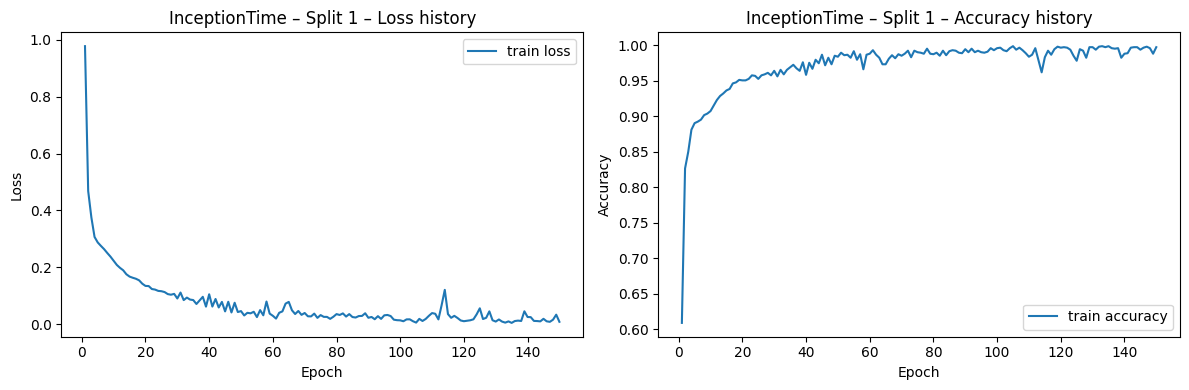

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Split 2/3 | random_state=43
model fitted.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Split 3/3 | random_state=44
model fitted.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

=== Summary (3 splits)  ===
batch_size：32,epochs：150,Classifiers:2,verbose:0
   split  random_state  val_accuracy  test_accuracy  test_balanced_accuracy  \
0      1            42      0.966006       0.970522                0.969028   
1      2            43      0.841360       0.845805                0.870139   
2      3            44      0.985836       0.972789                0.974861   

   test_f1_macro  test_f1_weighted  
0 

In [35]:
results_df, summary_df = train_inceptiontime_3splits_tunable(
    X_acht, y,
    base_seed=42,
    batch_size=32,
    n_epochs=150,
    n_classifiers=2,
    plot_history=True,
    plot_splits=(1,)
)


#### 3.4.2 8 Sensoren mit epoch 60
- Trainingsprozess ist stabil: <br/>
Der Trainingsverlust sinkt gleichmäßig und konvergiert(bei epochs ca.50,60) gegen null, während die Trainingsgenauigkeit sehr schnell Werte nahe 1.0 erreicht. Dies deutet auf einen stabilen und gut konvergierenden Trainingsprozess hin.

- Die Ergebnisse den drei Splits ist nicht stabil, sondern haben hohe Streuung: <br/>
Während im ersten und dritten Split eine Testgenauigkeit von etwa 97 % erreicht wird, liegt die Genauigkeit im zweiten Split nur bei ungefähr 87 %. Die Standardabweichung der Balanced Accuracy beträgt etwa 0,058.


- Dies weist darauf hin, dass drei Splits möglicherweise nicht ausreichen. aber dauert bestimmt lang. um den Trainingspozess schneller durchfzuführen, probiere ich zuerst kleiner epoch, z.B. 60, oder 30.


Split 1/3 | random_state=42
model fitted.


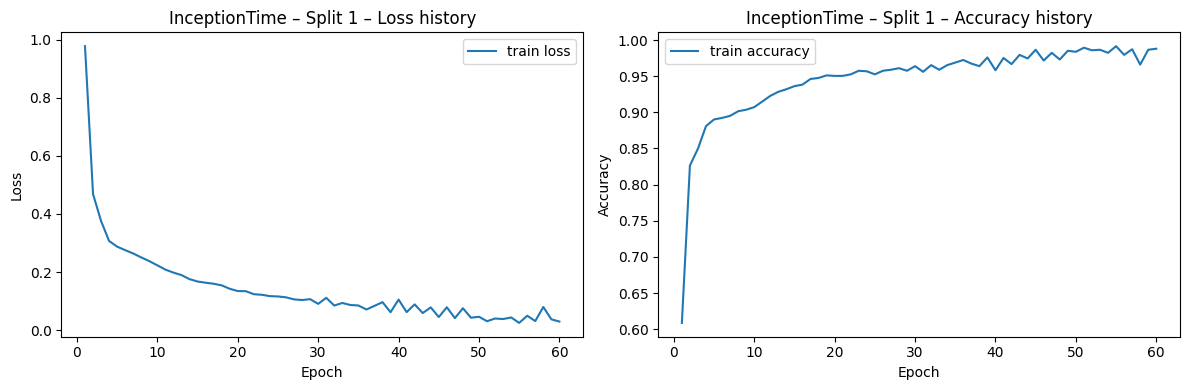

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Split 2/3 | random_state=43
model fitted.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Split 3/3 | random_state=44
model fitted.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

=== Summary (3 splits)  ===
batch_size：32,epochs：60,Classifiers:2,verbose:0
   split  random_state  val_accuracy  test_accuracy  test_balanced_accuracy  \
0      1            42      0.702550       0.727891                0.583333   
1      2            43      0.838527       0.841270                0.759306   
2      3            44      0.504249       0.512472                0.572222   

   test_f1_macro  test_f1_weighted  
0  

In [36]:
# probieren epoch=60
results_df, summary_df = train_inceptiontime_3splits_tunable(
    X_acht, y,
    base_seed=42,
    batch_size=32,
    n_epochs=60,
    n_classifiers=2,
    plot_history=True,
    plot_splits=(1,)
)

#### 3.4.3 8 Sensor mit 10 Splits mit Epoch 60
- Obwohl der Trainingsverlust nach 60 Epochen klar konvergiert und die Trainingsgenauigkeit sehr hoch ist, bleiben die Ergebnisse auf Validierungs- und Testdaten deutlich schlechter.
- Dies deutet auf eine eingeschränkte Generalisierungsfähigkeit hin (Overfitting bzw. hohe Varianz), insbesondere bei der reduzierten Sensoranzahl.
- Zusätzlich zeigen die drei Random-Splits eine hohe Streuung (Balanced Accuracy Std ≈ 0,105), was darauf hinweist, dass drei Splits nicht ausreichen, um die Modellleistung zuverlässig zu bewerten. Daher sollten mehr Wiederholungen (z. B. 10 Splits mit unterschiedlichen Seeds) durchgeführt werden.

In [38]:
train_inceptiontime_3splits_tunable(
     X_acht, y,
    base_seed=42,
    batch_size=32,
    n_epochs=60,
    n_classifiers=2,
    splits_menge=10,
    plot_history=False,
    plot_splits=(1,)
)



Split 1/3 | random_state=42
model fitted.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Split 2/3 | random_state=43
model fitted.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Split 3/3 | random_state=44
model fitted.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Split 4/3 | random_state=45
model fitted.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Split 5/3 | random_state=46
model fitted.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14/14 ━━━━━━━━━━━━━━━━━━

(   split  random_state  val_accuracy  test_accuracy  test_balanced_accuracy  \
 0      1            42      0.702550       0.727891                0.583333   
 1      2            43      0.838527       0.841270                0.759306   
 2      3            44      0.504249       0.512472                0.572222   
 3      4            45      0.940510       0.931973                0.928889   
 4      5            46      0.849858       0.848073                0.887778   
 5      6            47      0.818697       0.843537                0.835972   
 6      7            48      0.538244       0.535147                0.288194   
 7      8            49      0.847025       0.811791                0.905417   
 8      9            50      0.847025       0.854875                0.794306   
 9     10            51      0.985836       0.977324                0.979444   
 
    test_f1_macro  test_f1_weighted  
 0       0.551621          0.647232  
 1       0.697807          0.782242  
 2  

### 3.5 Trainieren mit 14 übrigen Sensoren von Ablation Experiment
- Die Ergebnisse von dem Experiment(8 Sensor mit Epoch60 und 10 Splits) schwankt sehr stark, hoch Streuung.
    - Es wurde schon beweist, dass Epoch 60, Batchsize 16 ausreichend ist.
- Das heißt, die Kombination 8 Sensor ist wahrscheinlich nicht so gut bei Inceptiontime.
- Ich würde die übrige 14 Sensor von Ablation Experiment von Inceptiontime nehmen und probieren.

In [ ]:
vierzehn_sensor=[
    "SE",
    "FS1",
    "TS1",
    "CE",
    "TS4",
    "EPS1",
    "VS1",
    "PS3",
    "PS5",
    "PS1",
    "PS6",
    "CP",
    "PS4",
    "PS2",
]

#Data Preparation
X_vierzehn = build_multivariate_X(
    sensor_data,
    target_len=60,
    sensor_order=vierzehn_sensor,
    resample_fn=resample_to_fixed_length,
    dtype=np.float32
)


results_14_df, summary_14_df = train_inceptiontime_3splits_tunable(
    X_vierzehn, y,
    base_seed=42,
    batch_size=32,
    n_epochs=60,
    n_classifiers=2,
    splits_menge=3,
    plot_history=True,
    plot_splits=(1,)
)